Try to implement a Markov chain class, using the example from [David Silver's RL class](https://www.youtube.com/watch?v=lfHX2hHRMVQ). Thinking about what data must be stored, what methods should be made available, and how to validate input.

In [179]:
import numpy as np


class MarkovProcess():
    def __init__(self, num_states, initial_state=None):
        self.P = np.zeros(shape=(num_states,num_states))
        self.num_states = num_states
        self.current_state = initial_state # initial state
        self.states_desc = None # state descriptors

    def set_P(self, P):
        """Set the transition probability matrix.
            Must ensure normalization and proper dimensionality.
        """
        assert P.shape == (self.num_states, self.num_states)
        assert (np.sum(P,axis=1) == np.ones((self.num_states))).all()
        self.P = P

    def step(self, desc=False) -> int:
        """Take a single step."""
        if self.current_state is not None:
            tt = np.random.choice(range(self.num_states),p=self.P[self.current_state,:])
        else:
            pass

        if desc:
            if self.states_desc is not None:
                print(self.states_desc[self.current_state], ' -> ',
                    self.states_desc[tt])

        self.current_state = tt
        return self.current_state

    def set_states_desc(self, states_desc):
        """Set state description dictionary, which
            maps state index to a description.
        """
        assert len(states_desc) == self.num_states
        self.states_desc = states_desc



    

In [180]:
states_desc = {
    0: "Class 1",
    1: "Class 2",
    2: "Class 3",
    3: "Pass",
    4: "Facebook",
    5: "Sleep",
    6: "Pub",
}

P = np.array([
        [0., 0.5, 0., 0., 0.5, 0., 0.], # row 0 (from class I to...)
        [0., 0., 0.8, 0., 0., 0.2, 0.],
        [0., 0., 0., 0.6, 0., 0., 0.4],
        [0., 0., 0., 0., 0., 1.0, 0.],
        [0.1, 0., 0., 0., 0.9, 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0.2, 0.4, 0.4, 0., 0., 0., 0.]
    ])

mp = MarkovProcess(P.shape[0],0) # start in class I
mp.set_states_desc(states_desc)
mp.set_P(P)


In [181]:
mp.current_state = 0
for j in range(20):
    mp.step(desc=True)

Class 1  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Facebook
Facebook  ->  Class 1
Class 1  ->  Class 2
Class 2  ->  Class 3
Class 3  ->  Pass
Pass  ->  Sleep
Sleep  ->  Sleep
Sleep  ->  Sleep
Sleep  ->  Sleep
Sleep  ->  Sleep
Sleep  ->  Sleep
Sleep  ->  Sleep


In [133]:
md = {0:"hi",1:"ho"}
list(md.keys())

[0, 1]

In [ ]:
np.array()

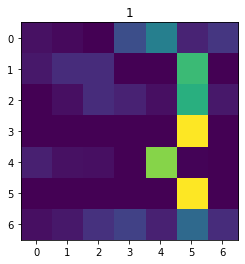

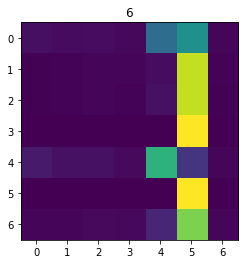

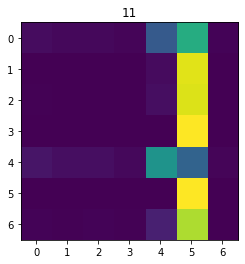

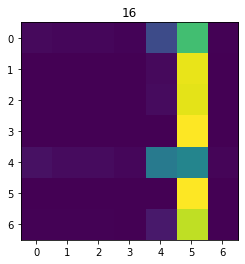

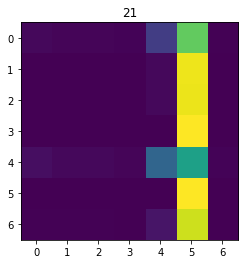

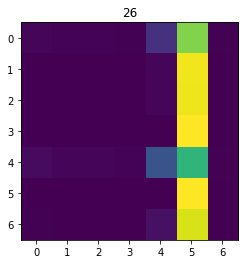

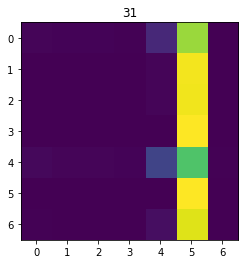

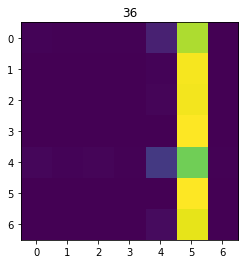

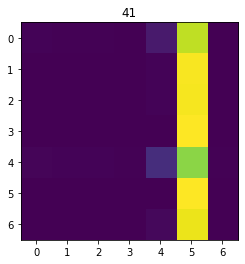

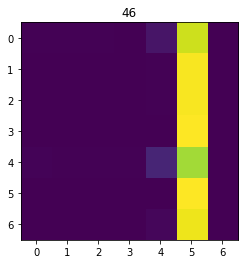

In [178]:
import matplotlib.pyplot as plt
from time import sleep 


plt.imshow(mp.P)
pt = mp.P
for j in range(50):
    pt = pt @ mp.P
    if (j-1) % 5 == 0:
        plt.imshow(pt)
        ax = plt.gca()
        ax.set_title(f'{j}')
        plt.show()

# Add value function

Assigns a particular value to a state

In [319]:
class MarkovRewardProcess(MarkovProcess):
    def __init__(self, num_states, gamma=0.):
        super().__init__(num_states)
        self.value_function = None
        self.total_return = 0.
        self.time_step = 0
        self.gamma = gamma

    def set_value_function(self, value_function):
        """Set the value function.
            Must ensure proper dimensionality.
        """
        assert len(value_function) == self.num_states
        self.value_function = value_function

    def step(self, desc=False) -> int:
        """Take a single step. Redefined from parent class!"""
        if self.current_state is not None:
            tt = np.random.choice(range(self.num_states),p=self.P[self.current_state,:])
        else:
            pass

        if desc:
            if self.states_desc is not None:
                print(self.states_desc[self.current_state], ' -> ',
                    self.states_desc[tt])

        self.current_state = tt

        if self.value_function is not None:
            if self.gamma > 0:
                self.total_return += (self.gamma ** self.time_step) * self.value_function[self.current_state] 
            self.time_step += 1.

        return (self.current_state, self.total_return)


In [320]:
value_function = {
    0: -2.,
    1: -2.,
    2: -2.,
    3: 10.,
    4: -1.,
    5: 0.,
    6: 1.,
}
gamma = 0.
mrp = MarkovRewardProcess(7, gamma=gamma)

mrp.set_P(P)
mrp.set_states_desc(states_desc)
mrp.set_value_function(value_function)
mrp.current_state = 0

In [321]:
for j in range(10):
    print(f"Total return: {mrp.step(desc=True)[1]:.5}")

Class 1  ->  Facebook
Total return: 0.0
Facebook  ->  Class 1
Total return: 0.0
Class 1  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0
Facebook  ->  Facebook
Total return: 0.0


We can compute the *value function*, $$ v\left(s\right) = \mathbb{E}\left[G_t \, \middle| \, S_t =s \right] $$ which specifies, for each state $s$, the expected return after starting in that state. We can compute this by running many simulations starting at state $s$, computing their return, and then averaging these returns.

In [340]:
num_sample = 1000 # number of samples for each starting state
len_sample = 50 # iterations
mrp.gamma = 0.9
exp_returns = {i:0. for i in range(mrp.num_states)}

for s in range(mrp.num_states): # for each state
    for sam in range(num_sample): # for each sample
        # initialize everything
        mrp.current_state = s
        mrp.total_return = 0
        mrp.time_step = 0

        for j in range(len_sample):
            mrp.step(desc=False)
        exp_returns[s] += mrp.total_return


exp_returns = {key:val/num_sample for key,val in exp_returns.items()}
        
        
for key, val in exp_returns.items():
    print(f"{mrp.states_desc[key]:>15}: {val:>10.5}")

        Class 1:     -3.306
        Class 2:      3.645
        Class 3:     6.8575
           Pass:        0.0
       Facebook:     -7.419
          Sleep:        0.0
            Pub:      1.059


In [341]:
mrp.P

array([[0. , 0.5, 0. , 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.8, 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0.6, 0. , 0. , 0.4],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0.1, 0. , 0. , 0. , 0.9, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0.2, 0.4, 0.4, 0. , 0. , 0. , 0. ]])

In [349]:
# value function: exact solution to Bellman equation
mrp.P @ np.array(list(mrp.value_function.values()))[:,None]

array([[-1.5],
       [-1.6],
       [ 6.4],
       [ 0. ],
       [-1.1],
       [ 0. ],
       [-2. ]])